In [1]:
pip uninstall tensorflow

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.7.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
y
y
y
y
y
  Successfully uninstalled tensorflow-2.7.0


In [2]:
pip install "tensorflow>=1.15.2,<2.0"

     |████████████████████████████████| 110.5 MB 1.2 kB/s 
     |████████████████████████████████| 503 kB 36.2 MB/s 
     |████████████████████████████████| 20.1 MB 6.6 MB/s 
     |████████████████████████████████| 3.8 MB 39.4 MB/s 
     |████████████████████████████████| 50 kB 3.7 MB/s 
     |████████████████████████████████| 2.9 MB 33.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=8ebb4750ecd66af93a4183243445b0b03542b46b082b9b0d65aa79c94b568ee7
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tens

In [5]:
# install AmpliGraph and other dependencies

%%capture 
# Install AmpliGraph library
! pip install ampligraph

# Required to visualize embeddings with tensorboard projector, comment out if not required!
! pip install --user tensorboard

# Required to plot text on embedding clusters, comment out if not required!
! pip install --user git+https://github.com/Phlya/adjustText

In [6]:
#check if tensorflow is correctly installed 
import tensorflow as tf 
print(tf.version.VERSION)

1.15.5


In [7]:
# All imports used in this notebook
%tensorflow_version 1.x
import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf
#from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE #ComplEx, HolE, DistMult, ConvE, ConvKB
#from ampligraph.utils import save_model, restore_model

'''def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))

print('Ampligraph version: {}'.format(ampligraph.__version__))'''

TensorFlow is already loaded. Please restart the runtime to change versions.


"def display_aggregate_metrics(ranks):\n    print('Mean Rank:', mr_score(ranks)) \n    print('Mean Reciprocal Rank:', mrr_score(ranks)) \n    print('Hits@1:', hits_at_n_score(ranks, 1))\n    print('Hits@10:', hits_at_n_score(ranks, 10))\n    print('Hits@100:', hits_at_n_score(ranks, 100))\n\nprint('Ampligraph version: {}'.format(ampligraph.__version__))"

In [8]:
import pandas as pd
from ampligraph.datasets import load_from_csv

true = load_from_csv('.', '/content/drive/MyDrive/results15.csv', sep=',') 
false = load_from_csv('.', '/content/drive/MyDrive/resultsf15.csv', sep = ',')

df_true = pd.DataFrame(true, columns = ['id', 'text', 'ratingName', 'author',  'headline', 'named_entities_claim', 'named_entities_article', 'keywords', 'source', 'sourceURL', 'link', 'language'])
df_false = pd.DataFrame(false, columns = ['id', 'text', 'ratingName', 'author', 'headline', 'named_entities_claim', 'named_entities_article', 'keywords', 'source', 'sourceURL', 'link', 'language'])

df_true['label'] = 0
df_false['label'] = 1

data = pd.concat([df_false, df_true])
# shuffle the dataset
data = data.sample(frac=1)

data.head()

,id,text,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language,label
9285,http://data.gesis.org/claimskg/claim_review/fa...,Essay by retired Air Force general analyzes th...,FALSE,Unknown,General Chong Letter,"e-mail forwarding,the chain,war on terrorism",war on terrorism,ASP Article,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/the-war-is-f...,English,1
1777,http://data.gesis.org/claimskg/claim_review/81...,The month of August will include five Saturday...,FALSE,Unknown,‘Money Bags’ Calendar,"feng shui,money bag",NaN,Trivia,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/money-bags/,English,1
8655,http://data.gesis.org/claimskg/claim_review/2c...,Oregon State Leaves Donald Trump off Ballots,FALSE,Unknown,Oregon State Leaves Donald Trump off Ballots-F...,"2016 presidential election,Donald Trump,Facebo...","Donald Trump,Oregon",NaN,truthorfiction,https://www.truthorfiction.com,https://www.truthorfiction.com/oregon-state-le...,English,1
5988,http://data.gesis.org/claimskg/claim_review/2b...,'The music industry is the biggest export from...,FALSE,D’Banj,Africa's 'Bono' claims that music is one of Af...,"Afrobeat,Akon,Azonto,Bollywood,Center for Stra...",NaN,"Ebola,Economy,Foreign Policy,Pop Culture",politifact,http://www.politifact.com,http://www.politifact.com/punditfact/statement...,English,1
3334,http://data.gesis.org/claimskg/claim_review/d2...,The Red Cross provided supplies to marchers in...,TRUE,Unknown,Red Cross Supplies Jena Marchers,"American Red Cross,Detroit Free Press,Dr. Mart...","Jena, Louisiana",ASP Article,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/jena-side/,English,0


In [9]:
data = data.drop(columns= 'ratingName')
data = data.drop(columns= 'sourceURL')
data = data.drop(columns = 'link')
data.head()

,id,text,author,headline,named_entities_claim,named_entities_article,keywords,source,language,label
9285,http://data.gesis.org/claimskg/claim_review/fa...,Essay by retired Air Force general analyzes th...,Unknown,General Chong Letter,"e-mail forwarding,the chain,war on terrorism",war on terrorism,ASP Article,snopes,English,1
1777,http://data.gesis.org/claimskg/claim_review/81...,The month of August will include five Saturday...,Unknown,‘Money Bags’ Calendar,"feng shui,money bag",NaN,Trivia,snopes,English,1
8655,http://data.gesis.org/claimskg/claim_review/2c...,Oregon State Leaves Donald Trump off Ballots,Unknown,Oregon State Leaves Donald Trump off Ballots-F...,"2016 presidential election,Donald Trump,Facebo...","Donald Trump,Oregon",NaN,truthorfiction,English,1
5988,http://data.gesis.org/claimskg/claim_review/2b...,'The music industry is the biggest export from...,D’Banj,Africa's 'Bono' claims that music is one of Af...,"Afrobeat,Akon,Azonto,Bollywood,Center for Stra...",NaN,"Ebola,Economy,Foreign Policy,Pop Culture",politifact,English,1
3334,http://data.gesis.org/claimskg/claim_review/d2...,The Red Cross provided supplies to marchers in...,Unknown,Red Cross Supplies Jena Marchers,"American Red Cross,Detroit Free Press,Dr. Mart...","Jena, Louisiana",ASP Article,snopes,English,0


In [10]:
#knowledge graph creation
# naming entities
#data['id'] = data.index.values.astype(str)
data['id'] =  data.id # "Claim" +
data['text'] = data.text #"Text" + 
#data['ratingName'] =  data.ratingName #"RatingName" 
data['author'] = data.author #"Author" + 
data['headline'] = data.headline #"Headline" +
data['named_entities_claim'] = data.named_entities_claim #"Named_entities_claim" + 
data['named_entities_article'] =  data.named_entities_article #"Named_entities_article" +
data['keywords'] =  data.keywords #"Keywords" +
data['source'] = data.source #"Source" + 
#data['sourceURL'] =  data.sourceURL #"SourceURL" +
#data['link'] =  data.link #"Link" +
data['language'] = data.language # "Language" +
data['label'] = data.label


In [11]:
triples = []
for _, row in data.iterrows():
    # Home and away information
    text = (row['id'], "hasText", row['text'])
   # rating = (row['id'], "isRated", row['ratingName'])
    author = (row['id'], "isWrittenBy", row['author'])
    headline = (row['id'], "hasHeadline", row['headline'])
    named_entities_claim = (row['id'], "referredEntities", row["named_entities_claim"])
    keywords = (row['id'], "containKeywords", row['keywords'])
    language = (row['id'], "isWrittenIn", row['language'])
    source = (row['id'], "isLocated", row['source'])
   # sourceURL = (row['id'], "URL", row['sourceURL'])
    label = (row['id'], "isLabelled", row['label'])



    triples.extend((text, author, headline, named_entities_claim, keywords, language, source, label))


In [12]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.head()

,subject,predicate,object
0,http://data.gesis.org/claimskg/claim_review/fa...,hasText,Essay by retired Air Force general analyzes th...
1,http://data.gesis.org/claimskg/claim_review/fa...,isWrittenBy,Unknown
2,http://data.gesis.org/claimskg/claim_review/fa...,hasHeadline,General Chong Letter
3,http://data.gesis.org/claimskg/claim_review/fa...,referredEntities,"e-mail forwarding,the chain,war on terrorism"
4,http://data.gesis.org/claimskg/claim_review/fa...,containKeywords,ASP Article


In [13]:
t_size = int(len(triples) * 0.20)
print(t_size)

23126


In [15]:
from ampligraph.evaluation import train_test_split_no_unseen 
 
''' 
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(np.array(triples), 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, test_size=10000, seed=0)'''

#X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=t_size)

X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=10000)



In [16]:
print('Train set size: ', X_train.shape)
#print('Valid set size: ', X_valid.shape)
print('Test set size: ', X_test.shape)

Train set size:  (105632, 3)
Test set size:  (10000, 3)


In [ ]:
#X = np.concatenate([X_train, X_valid])

In [17]:
from ampligraph.latent_features import TransE

model = TransE(k=150,                                                             # embedding size
               epochs=100,                                                        # Num of epochs
               batches_count= 10,                                                 # Number of batches 
               eta=1,                                                             # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(X_train)
# model.fit(X)

Average TransE Loss:   0.030257: 100%|██████████| 100/100 [03:28<00:00,  2.08s/epoch]


# **EVALUATION METRICS**
1. Τo evaluate accuracy, test triples are considered positive and negative triples are derived from them. The evaluation protocol is thus impacted by the generation of negative triples, which remains to be analyzed.

2.  While evaluating (as described earlier), we generate all the corruptions (using all the unique entities in our dataset) per test triple, score and rank them. While doing so, we are not filtering the true positives - in other words, some of the corruptions may not really be corruptions and may be ground truth triples observed during training.  Training triples usually get a high score as they are "observed" by the model. Hence a test triple would get a lower rank if such triples appear in corruptions. To filter out the True Positives (after step b. and e.), one can pass all  the True Positive triples to filter_triples parameter of the evaluate_performance API. This will perform a "filtered" evaluation and return the "filtered" ranks adjusted by removing the True Positives from the corruptions.

In [ ]:
'''# per triple metrics
#This is a metric that is computed for each test set triple:
#score: This is the value assigned to a triple, by the model, by applying the scoring function.
#Let's look at how we can get the score for a triple of interest and how to interpret it.

test_triple = ['http://data.gesis.org/claimskg/claim_review/1a3dca4b-efcc-53cf-ad0a-28caca6395b9', 
               'hasheadline', 
               "Donald Trump in Florida laments 'what's happening last night in Sweden.' But nothing happened"]

triple_score = model.predict(test_triple)

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)'''

'# per triple metrics\n#This is a metric that is computed for each test set triple:\n#score: This is the value assigned to a triple, by the model, by applying the scoring function.\n#Let\'s look at how we can get the score for a triple of interest and how to interpret it.\n\ntest_triple = [\'http://data.gesis.org/claimskg/claim_review/1a3dca4b-efcc-53cf-ad0a-28caca6395b9\', \n               \'hasheadline\', \n               "Donald Trump in Florida laments \'what\'s happening last night in Sweden.\' But nothing happened"]\n\ntriple_score = model.predict(test_triple)\n\nprint(\'Triple of interest:\n\', test_triple)\nprint(\'Triple Score:\n\', triple_score)'

In [ ]:
# Evaluating knowledge embeddings


from ampligraph.evaluation import evaluate_performance 

print('Size of X_test:', X_test.shape)

# Append the Train, Valid and Test set to the X_filter.
''' The model has not "observed" them during training. We do so because, we would like
   to evaluate a test triple against it's corruptions and not against known facts. 
   If we know that the Validation triples and Test triples are facts (and not queries),
   we need to filter these triples out of the generated corruptions. This is the standard 
   procedure that is used to compute the metrics to compete on the leadership board.'''

X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter)

print(ranks)

Size of X_test: (10000, 3)
WARNING - You are attempting to use 66055 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.


/usr/local/lib/python3.7/dist-packages/ampligraph/evaluation/protocol.py:952: UserWarning: You are attempting to use 66055 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.
  warnings.warn(warn_msg % ent_for_corruption_size)
100%|██████████| 10000/10000 [24:04<00:00,  6.92it/s]


[[ 1332     1]
 [   80     1]
 [  267     1]
 ...
 [  292     1]
 [12203   843]
 [ 2691     1]]


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.35
MR: 2277.69
Hits@10: 0.42
Hits@3: 0.37
Hits@1: 0.30


In [ ]:
yt = pd.DataFrame(X_train, columns=['subject', 'predicate', 'object'])
X2_train = X_train
y2t = yt.loc[yt['predicate'] == 'isLabelled']
y2_train = y2t['object']
y2_train.head()
len(y2_train)

X_t = pd.DataFrame(X_train, columns=['subject', 'predicate', 'object'])
X_t.head()
X2_train = X_t['subject']
type(X2_train)

yte = pd.DataFrame(X_test, columns=['subject', 'predicate', 'object'])
X2_test = X_test
y2te = yte.loc[yte['predicate'] == 'isLabelled']
y2_test= y2te['object']
len(y2_test)

X_te = pd.DataFrame(X_test, columns=['subject', 'predicate', 'object'])
X_te.head()
X2_test = X_te['subject']
len(X2_test)

print('Train set TransE:', len(X_train))
print('Train set X for XGB classifier:', len(X2_train))
print('Train set y for XGB classifier:', len(y2_train))

print('******')

print('Test set TransE:', len(X_test))
print('Test set X for XGB classifier:', len(X2_test))
print('Test set y for XGB classifier:', len(y2_test))

In [18]:
from sklearn.model_selection import train_test_split

y = data['label']
X1_train, X1_test, y1_train, y1_test = train_test_split(data['id'], y, test_size=0.20, random_state=42)

print('X1_train:', len(X1_train))
print('y1_train:', len(y1_train))
print('****')
print('X1_test:', len(X1_test))
print('y1_train:', len(y1_test))

X1_train: 11563
y1_train: 11563
****
X1_test: 2891
y1_train: 2891


In [19]:
data.label.value_counts(normalize=True)

1    0.691919
0    0.308081
Name: label, dtype: float64

In [20]:
X_train_clf = model.get_embeddings(X1_train)
X_test_clf = model.get_embeddings(X1_test)

In [21]:
from xgboost import XGBClassifier

clf_model = XGBClassifier(n_estimators=500, max_depth=5, binary="logistic")

clf_model.fit(X_train_clf,y1_train)

XGBClassifier(binary='logistic', max_depth=5, n_estimators=500)

In [22]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y1_test,  clf_model.predict(X_test_clf)))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       907
           1       0.94      0.97      0.95      1984

    accuracy                           0.93      2891
   macro avg       0.93      0.91      0.92      2891
weighted avg       0.93      0.93      0.93      2891



**20/01/20222**: With columns ratingName, sourceURL, link --> Accuracy 88%


**26/01/2022**: 
1.   Drop the columns ratingName, sourceURL, link. And column label --> Accuracy 94%
2.   Train_set without column label in TRANSE model --> Accuracy 68%



In [23]:
from ampligraph.latent_features import ComplEx

model1 = ComplEx(batches_count=50,
                epochs=100,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model1.fit(X_train)

Average ComplEx Loss:   1.269061: 100%|██████████| 100/100 [39:36<00:00, 23.76s/epoch]


In [24]:
X_train_clf = model1.get_embeddings(X1_train)
X_test_clf = model1.get_embeddings(X1_test)

In [25]:
from xgboost import XGBClassifier

clf_model = XGBClassifier(n_estimators=500, max_depth=5, binary="logistic")

clf_model.fit(X_train_clf,y1_train)

XGBClassifier(binary='logistic', max_depth=5, n_estimators=500)

In [26]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y1_test,  clf_model.predict(X_test_clf)))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       907
           1       0.95      0.98      0.96      1984

    accuracy                           0.95      2891
   macro avg       0.94      0.93      0.94      2891
weighted avg       0.95      0.95      0.94      2891



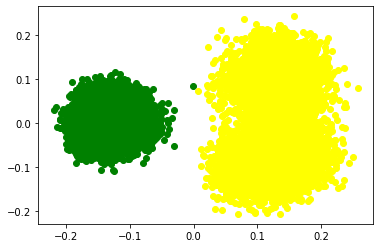

In [ ]:
#Import required module
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
 
# Create a dictionary with the embeddings of all claims

claims = data['id']
claims_embeddings = dict(zip(claims, model.get_embeddings(claims)))

embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in claims_embeddings.values()]))
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans.fit_predict(embeddings_2d)
 
#print(label)

 
#filter rows of original data
filtered_label0 = embeddings_2d[label== 0] 
filtered_label1 = embeddings_2d[label == 1]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'green')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'yellow')
plt.show()